# Predicting Heart Disease from Cleveland Database  

Authors: Albert C. Halim, Archer Liu, Stephanie Wu, & Ziyuan Zhao  
Date: November 29, 2024

# Summary

In this project, we developed and evaluated several classification models to predict the presence of heart disease using the Cleveland Heart Disease dataset, which includes various clinical features. We compared four models: Logistic Regression, Support Vector Classifier (SVC), Dummy Classifier (as a baseline), and Decision Tree Classifier. Logistic Regression performed the best, achieving high accuracy of `0.83517` and providing interpretable coefficients that helped us understand the impact of each feature on heart disease prediction. The SVC also performed well but slightly lagged behind Logistic Regression in test accuracy with 0.82418. The Dummy Classifier served as a baseline, emphasizing the need for more sophisticated models, while the Decision Tree Classifier showed reasonable performance but tended to overfit. Misclassifications were analyzed to identify potential feature engineering opportunities, and future work could include exploring alternative classifiers such as Random Forests. Additionally, incorporating probability estimates into predictions would enhance the model's clinical usability, providing clinicians with more confidence in the results.

# Introduction

According to a 2022 CDC federal report, the leading cause of death in the United States is heart disease (Centers for Disease Control and Prevention [CDC], 2022). At 702,880 deaths that year, the disease claimed the most lives out of popular longevity doctor Peter Attia's so-called four horsemen, and nearly as many as cancer and diabetes (two of his other horsemen) combined (Attia, 2023). Despite past efforts having led to promising declines in mortality rates, the disease has gained traction within the last 5 years in particular (Bui, 2024). As such, early detection of heart disease, not to mention increased understanding of and heightened mindfulness around mitigating the risk factors for heart disease, can help improve countless lives in the United States and elsewhere.

Here we ask if we can use a machine learning algorithm to predict whether an individual has the presence of heart disease given a relevant selection of their bioinformatic data. Answering this question is important because both patients and their health teams can seek to benefit from tooling and technologies that help in the diagnostic process of such a prevalent disease. Given such prevalence, not to mention the potential gravity of heart-related conditions, detecting heart disease accurately and early on with a scalable solution in medical settings can help enhance medical care in terms of both timeliness and preparedness, to name a few aspects. Thus, if a machine learning algorithm can accurately and effectively predict whether an individual may harbour this disease early on, this could advance the timeline of early intervention, scale heart disease diagnosis efforts, and lead to better patient outcomes, as well as reduce the risk of future complications implicated with having heart disease.

# Methods

## Data

For this project, we will be using the Heart Disease UCI dataset created by R. Detrano, A. Jánosi, W. Steinbrunn, M. Pfisterer, J. Schmid, S. Sandhu, K. Guppy, S. Lee, and V. Froelicher at the Department of Medicine, Veterans Administration Medical Center, Long Beach, California (Detrano et al., 1988). It was sourced from the UC Irvine Machine Learning Repository (Detrano et al., 1988) and can be found [here](https://archive.ics.uci.edu/dataset/45/heart+disease). The specific file used represents the Cleveland locality. The dataset contains 303 rows, with each row representing summary statistics for a particular patient, and 14 columns with 13 features and 1 target variable. The target variable is the diagnosis of heart disease (angiographic disease status), and the value 0 is for no diagnosis of heart disease and the value 1 is for the diagnosis of heart disease. The 13 features are as follows:

- Age
- Sex
- Chest pain type
- Resting blood pressure
- Serum cholesterol
- Fasting blood sugar
- Resting electrocardiographic
- Maximum heart rate achieved
- Exercise induced angina
- Oldpeak = ST depression induced by exercise relative to rest
- The slope of the peak exercise ST segment
- Number of major vessels
- Thalassemia blood disorder

They are encoded in the dataset as follows:

- \#3 (age)
- \#4 (sex)
- \#9 (cp)
- \#10 (trestbps)
- \#12 (chol)
- \#16 (fbs)
- \#19 (restecg)
- \#32 (thalach)
- \#38 (exang)
- \#40 (oldpeak)
- \#41 (slope)
- \#44 (ca)
- \#51 (thal)
- \#58 (num) (the predicted attribute)

## Analysis

In this project, we used the Logistic Regression, SVC, Decision Tree, and Dummy Classifier as a baseline to build a classification model aimed at predicting the presence of heart disease based on clinical features. We used all available features from the dataset, excluding some variables related to the error of certain measurements. The data was split into a training set (70%) and a test set (30%). To choose the best value for the hyperparameter k, we used 5-fold cross-validation, with accuracy as the classification metric. We also standardized the data before fitting the model to ensure the features were on a similar scale. The analysis was carried out using Python, with the following libraries: NumPy, Pandas, scikit-learn, and Matplotlib.

# Results & Discussion

In [1]:
# File handling
import os
import requests
import zipfile

# Data handling
import numpy as np
import pandas as pd

# Preprocessing
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer

# Machine Learning
from scipy.stats import expon, lognorm, loguniform, randint, uniform, norm
from sklearn.model_selection import  RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.pipeline import make_pipeline, Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

# Scoring Metrics
from sklearn.metrics import roc_auc_score, average_precision_score, make_scorer, f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Visualization
import matplotlib.pyplot as plt

# Data Validation
import pandera as pa
from pandera import Column, Check, DataFrameSchema
from deepchecks.tabular import Dataset
from deepchecks.tabular.checks import FeatureLabelCorrelation, FeatureFeatureCorrelation

# Suppress irrelavant warnings
import warnings

In [2]:
# Create the directory if it doesn't exist
raw_dir = "../data/raw"
if not os.path.exists(raw_dir):
    os.makedirs(raw_dir)

# Download data as zip
url = "https://archive.ics.uci.edu/static/public/45/heart+disease.zip"
response = requests.get(url)

# Save the zip file to the specified directory
zip_path = os.path.join(raw_dir, "heart+disease.zip")
with open(zip_path, 'wb') as f:
    f.write(response.content)

# Extract the contents of the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(raw_dir)

### Data Validation

In [3]:
# read in data
colnames = [
    "age",       
    "sex",       
    "cp",        
    "trestbps",  
    "chol",      
    "fbs",       
    "restecg",   
    "thalach",   
    "exang",     
    "oldpeak",   
    "slope",     
    "ca",        
    "thal",      
    "num"  
]

# Load the data (without header since we specify the column names)
file_path = os.path.join(raw_dir, "processed.cleveland.data")
# --- Check 1: Ensure the raw file is in correct format ---
if not file_path.endswith(".data"):
    print("Warning: The file extension is not .data. It should be a .data file.")
else:
    print("File is in the expected format.")

heart_disease = pd.read_csv(file_path, names=colnames, header=None)
# --- Check 1.5: Ensure the read file is in correct format ---
if not file_path.endswith(".csv"):
    print("Warning: The file extension is not .csv. It should be a .csv file.")
else:
    print("File is in the expected format.")
# --- Check 2: Ensure correct column names ---
expected_columns = set(colnames)
actual_columns = set(heart_disease.columns)

if expected_columns != actual_columns:
    print(f"Warning: Column names do not match. Expected: {colnames}, Found: {heart_disease.columns.tolist()}")
else:
    print("Column names are correct.")

# --- Check 3: Ensure there are no empty observations ---
# Check for any rows with missing values (NaN)
missing_data = heart_disease.isna().sum().sum()  # Total number of missing values

if missing_data > 0:
    print(f"Warning: There are {missing_data} missing values in the dataset.")
else:
    print("No missing values found in the dataset.")
# Replace missing values with nan for ease of computational handling
heart_disease.replace('?', np.nan, inplace=True)

# Update the target variable 'num' (map values greater than 1 to 1)
heart_disease['num'] = heart_disease['num'].apply(lambda x: 1 if x > 1 else x)

File is in the expected format.
Column names are correct.
No missing values found in the dataset.


In [4]:
# ---- Check 4: Missingness not beyond expected threshold ----
# Set acceptable threshold for missing data (e.g., no more than 10%)
acceptable_threshold = 0.1

# Calculate the proportion of missing values in each column
missing_proportions = heart_disease.isna().mean()

# Check if any column exceeds the acceptable threshold
for column, proportion in missing_proportions.items():
    if proportion > acceptable_threshold:
        print(f"Warning: Missing values in column '{column}' exceed the acceptable threshold ({proportion:.2%}).")
    else:
        print(f"Column '{column}' has acceptable missingness ({proportion:.2%}).")
print("------------------------")

# ---- Check 5,7,8,9: Correct data types in each column, ----
# ---- No outlier or anomalous values, Correct category levels, Target/response variable follows expected distribution ----
heart_disease["ca"] = heart_disease["ca"].astype('float64')
# Define the schema
schema = DataFrameSchema({
    "age": pa.Column(float, pa.Check.between(0, 100)),  # Assuming ages are within a valid range
    "sex": pa.Column(float, pa.Check.isin([0.0, 1.0])),  # 0: female, 1: male
    "cp": pa.Column(float, pa.Check.isin([1.0, 2.0, 3.0, 4.0])),  # Chest pain types
    "trestbps": pa.Column(float, pa.Check.between(20, 220)),  # Resting blood pressure (reasonable range)
    "chol": pa.Column(float, pa.Check.between(50, 800)),  # Serum cholesterol (mg/dL)
    "fbs": pa.Column(float, pa.Check.isin([0.0, 1.0])),  # Fasting blood sugar > 120 mg/dL (0: no, 1: yes)
    "restecg": pa.Column(float, pa.Check.isin([0.0, 1.0, 2.0])),  # Resting ECG results
    "thalach": pa.Column(float, pa.Check.between(50, 240)),  # Maximum heart rate achieved
    "exang":  pa.Column(float, pa.Check.isin([0.0, 1.0])),  # Exercise-induced angina (0: no, 1: yes)
    "oldpeak": pa.Column(float, pa.Check.between(0.0, 7.0)),  # ST depression induced by exercise
    "slope": pa.Column(float, pa.Check.isin([1.0, 2.0, 3.0])),  # Slope of peak exercise ST segment
    "ca": pa.Column(float, pa.Check.between(0, 4), nullable=True),  # Number of major vessels colored by fluoroscopy
    "thal": pa.Column(str, pa.Check.isin(["3.0", "6.0", "7.0"]), nullable=True),  # Thalassemia types
    "num": pa.Column(int, pa.Check.between(0, 4)),  # Diagnosis of heart disease (0: no disease to 4: severe disease)
})

# Apply the schema to validate the dataframe
try:
    schema.validate(heart_disease, lazy=True)
    print("Data validation passed successfully.")
except pa.errors.SchemaErrors as e:
    print(e.failure_cases)
print("------------------------")

# ---- Check 6: No duplicate observations ----
# Check for duplicate rows
duplicate_rows = heart_disease.duplicated().sum()

if duplicate_rows > 0:
    print(f"Warning: There are {duplicate_rows} duplicate rows in the dataset.")
else:
    print("No duplicate rows found in the dataset.")

Column 'age' has acceptable missingness (0.00%).
Column 'sex' has acceptable missingness (0.00%).
Column 'cp' has acceptable missingness (0.00%).
Column 'trestbps' has acceptable missingness (0.00%).
Column 'chol' has acceptable missingness (0.00%).
Column 'fbs' has acceptable missingness (0.00%).
Column 'restecg' has acceptable missingness (0.00%).
Column 'thalach' has acceptable missingness (0.00%).
Column 'exang' has acceptable missingness (0.00%).
Column 'oldpeak' has acceptable missingness (0.00%).
Column 'slope' has acceptable missingness (0.00%).
Column 'ca' has acceptable missingness (1.32%).
Column 'thal' has acceptable missingness (0.66%).
Column 'num' has acceptable missingness (0.00%).
------------------------
Data validation passed successfully.
------------------------
No duplicate rows found in the dataset.


In [5]:
# Suppress the FutureWarning related to is_categorical_dtype
warnings.filterwarnings('ignore', category=FutureWarning, message=".*is_categorical_dtype.*")

# ---- Check 10: No anomalous correlations between target and explanatory variables ----
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
heart_disease_ds = Dataset(heart_disease, label='num', cat_features=categorical_features)

check_feat_lab_corr = FeatureLabelCorrelation().add_condition_feature_pps_less_than(0.9)
check_feat_lab_corr_result = check_feat_lab_corr.run(dataset=heart_disease_ds)
check_feat_lab_corr.run(dataset=heart_disease_ds).show()
if not check_feat_lab_corr_result.passed_conditions():
    raise ValueError("Feature-Target correlation exceeds the maximum acceptable threshold.")

# ---- Check 11: No anomalous correlations between explanatory variables ----
check_feat_feat_corr = FeatureFeatureCorrelation(threshold=0.9)
check_feat_feat_corr_result = check_feat_feat_corr.run(dataset=heart_disease_ds)
check_feat_feat_corr.run(dataset=heart_disease_ds).show()

if not check_feat_feat_corr_result.passed_conditions():
    raise ValueError("Feature-Feature correlation exceeds the maximum acceptable threshold.")

In [6]:
# Scale and split into train & test
np.random.seed(522)
set_config(transform_output="pandas")

# Create the split
heart_disease_train, heart_disease_test = train_test_split(
    heart_disease, train_size=0.70, stratify=heart_disease["num"]
)
# Create the directory if it doesn't exist
processed_dir = "../data/processed"
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)
heart_disease_train.to_csv("../data/processed/heart_disease_train.csv")
heart_disease_test.to_csv("../data/processed/heart_disease_test.csv")

In [7]:
results_dir = "../results"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Load the raw data
file_path = "../data/processed/heart_disease_train.csv"  # Adjusted name
raw_data = pd.read_csv(file_path)
print(raw_data.head())

   Unnamed: 0   age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  \
0         240  41.0  1.0  2.0     110.0  235.0  0.0      0.0    153.0    0.0   
1         139  51.0  1.0  3.0     125.0  245.0  1.0      2.0    166.0    0.0   
2          20  64.0  1.0  1.0     110.0  211.0  0.0      2.0    144.0    1.0   
3         196  69.0  1.0  1.0     160.0  234.0  1.0      2.0    131.0    0.0   
4          66  60.0  1.0  3.0     140.0  185.0  0.0      2.0    155.0    0.0   

   oldpeak  slope   ca  thal  num  
0      0.0    1.0  0.0   3.0    0  
1      2.4    2.0  0.0   3.0    0  
2      1.8    2.0  0.0   3.0    0  
3      0.1    2.0  1.0   3.0    0  
4      3.0    2.0  0.0   3.0    1  


<div style="background-color:#cce7ff; padding:15px; border-radius:5px; border: 2px solid #007acc;">
    <h2 style="color:#007acc;">📊 Visualization Section</h2>
    <p style="font-size:14px; color:#005f99;">
        The following plots provide insights into the dataset, including target variable distribution, categorical feature relationships, 
        and model performance (confusion matrix). Each visualization highlights critical aspects of the analysis.
    </p>
</div>


### Data Set Summary

The heart disease dataset used in this project is obtained from the UC Irvine Machine Learning Repository. The dataset contains 13 features, and the target is a binary variable (`num`) where:

- **`0`**: No presence of heart disease
- **`1` or higher**: Presence of heart disease.

Out of the 13 features:
- **8 are categorical** (e.g., `sex`, `cp`, `thal`).
- **5 are numeric** (e.g., `age`, `chol`, `thalach`).

These features include various physiological parameters, such as:
- **Resting blood pressure**,
- **Serum cholesterol levels**,
- **Maximum heart rate achieved**.

Additionally, it records potential signs of heart disease, such as chest pain type (`cp`) and exercise-induced angina (`exang`).

The dataset contains **303 observations**, and the original study used a Bayesian model to estimate the probability of having heart disease (Robert et al., 1989).


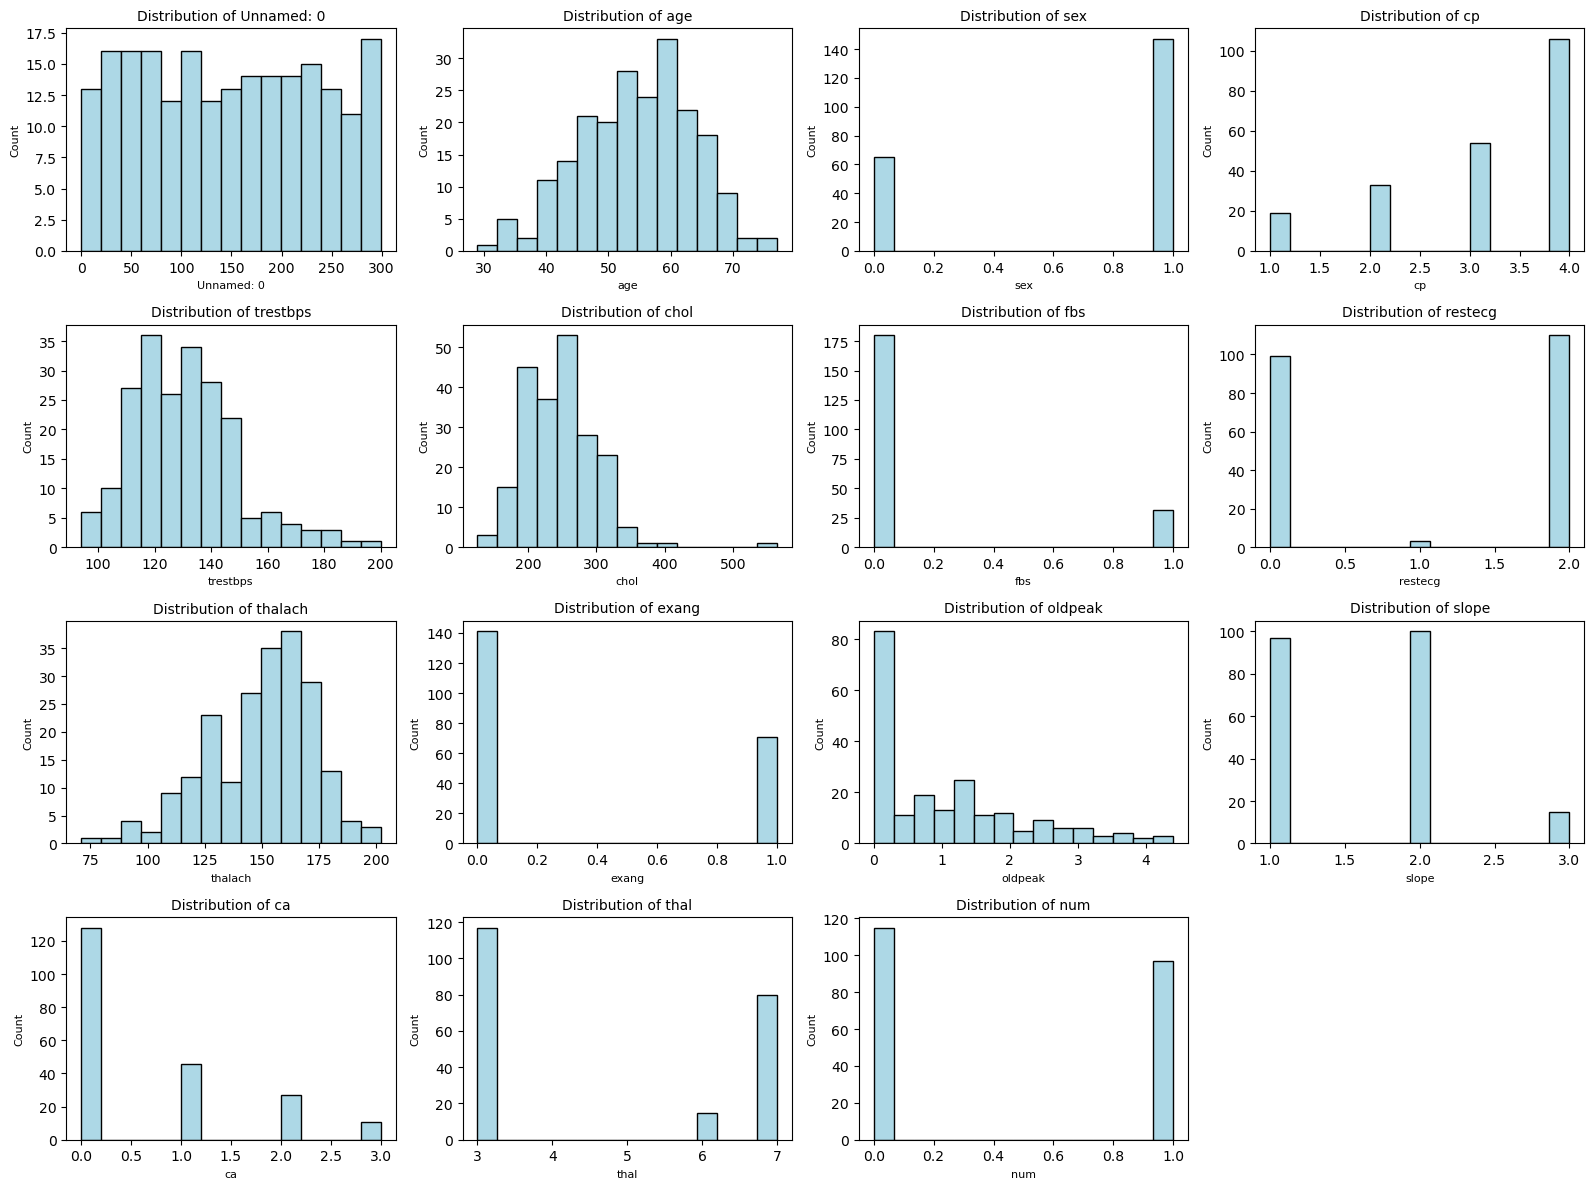

In [8]:
# General feature analysis for numeric features
numeric_features = raw_data.select_dtypes(include=["float64", "int64"]).columns

plt.figure(figsize=(16, 12))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(4, 4, i)  # Adjust rows/columns as needed
    plt.hist(raw_data[feature], bins=15, color="lightblue", edgecolor="black")
    plt.title(f"Distribution of {feature}", fontsize=10)
    plt.xlabel(feature, fontsize=8)
    plt.ylabel("Count", fontsize=8)
plt.tight_layout()
plt.savefig(f"{results_dir}/raw_feature_distributions.png", dpi=300)
plt.show()

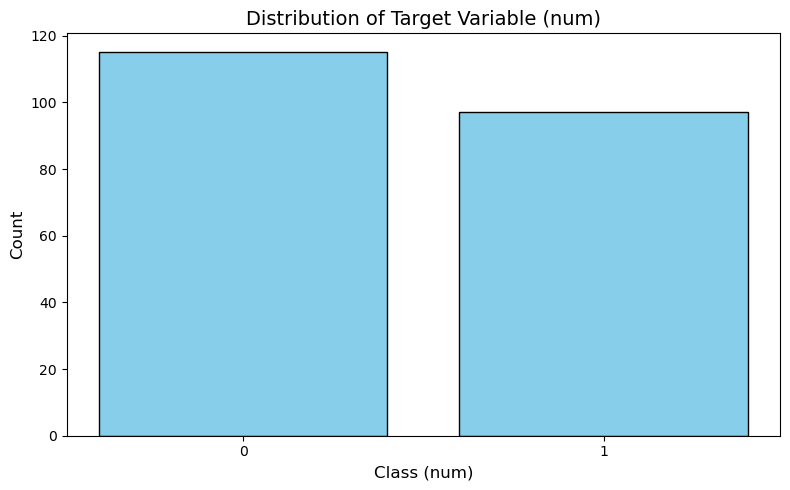

In [9]:
# Count the occurrences of each class in "num"
target_counts = raw_data["num"].value_counts()

# Plot the target variable distribution
plt.figure(figsize=(8, 5))
plt.bar(target_counts.index, target_counts.values, color="skyblue", edgecolor="black")
plt.title("Distribution of Target Variable (num)", fontsize=14)
plt.xlabel("Class (num)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(target_counts.index, fontsize=10)
plt.tight_layout()

# Save the plot
plt.savefig(f"{results_dir}/target_variable_distribution.png", dpi=300)
plt.show()

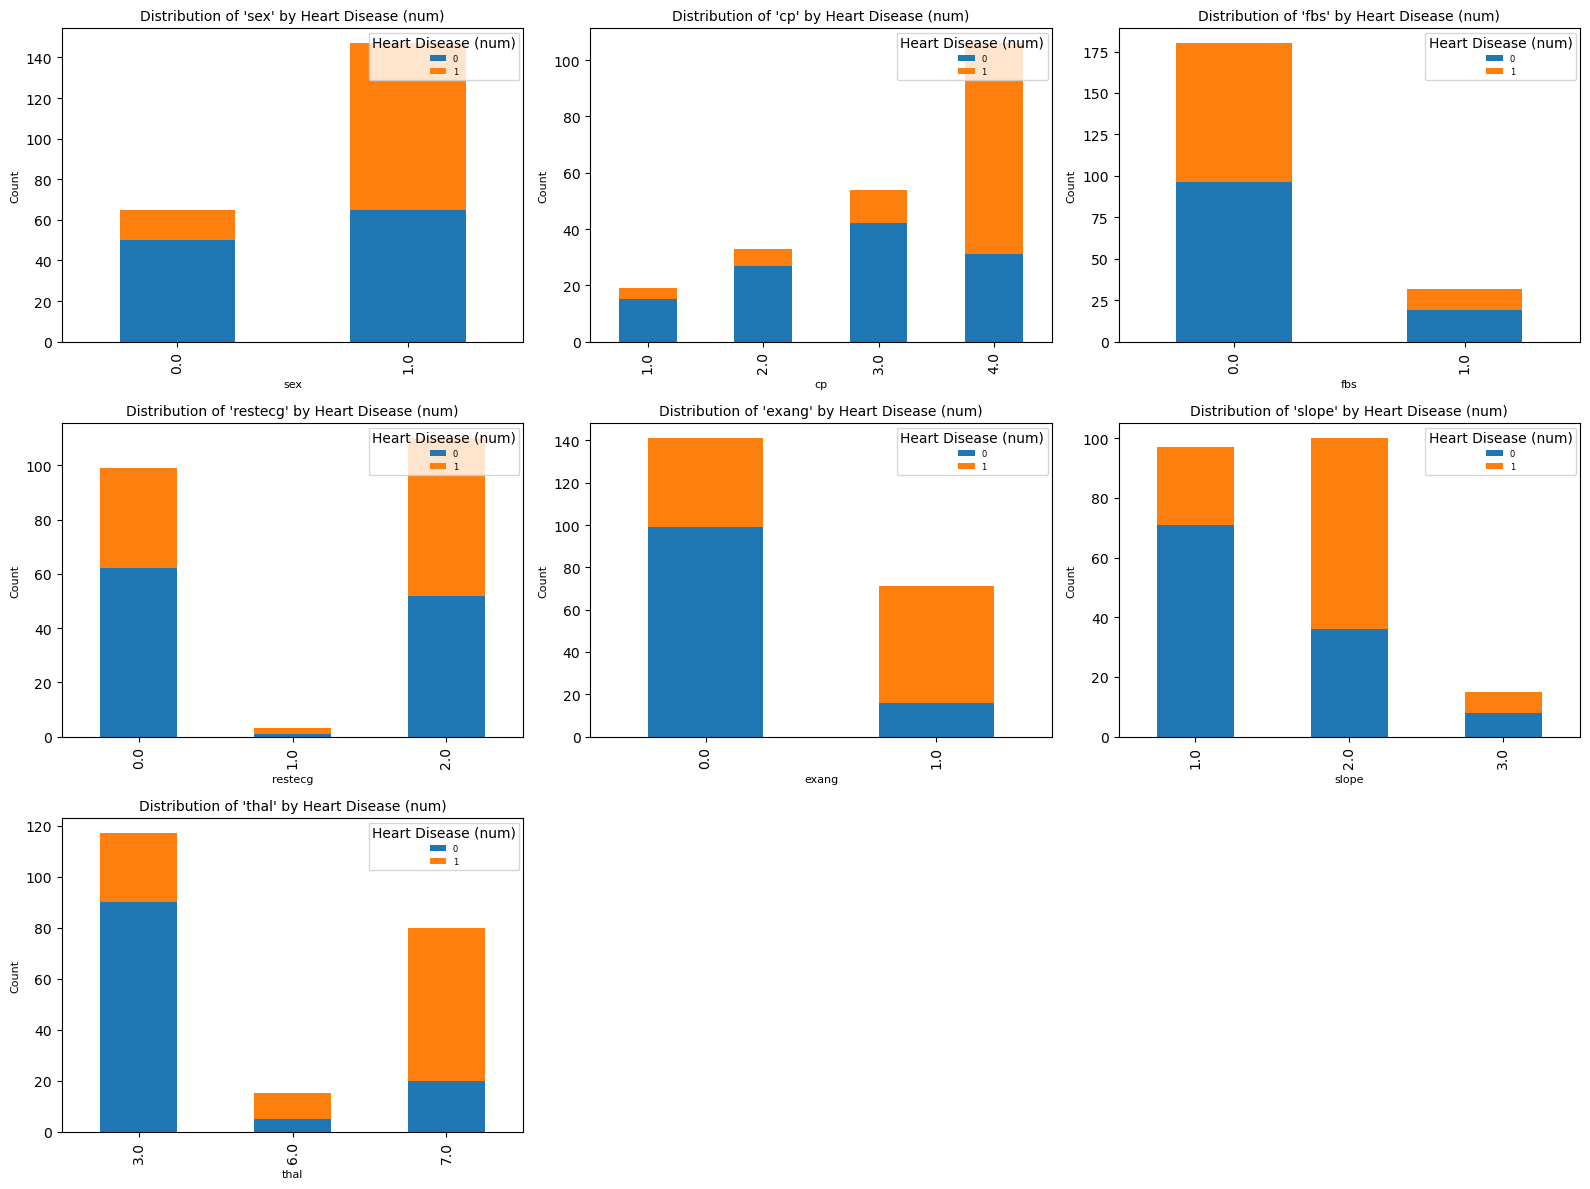

In [10]:
# List of categorical features to visualize
categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]

# Create subplots for all categorical variables
plt.figure(figsize=(16, 12))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)  # Adjust rows/columns based on the number of features
    counts = raw_data.groupby([feature, 'num']).size().unstack()
    counts.plot(kind='bar', stacked=True, ax=plt.gca(), color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"])
    plt.title(f"Distribution of '{feature}' by Heart Disease (num)", fontsize=10)
    plt.xlabel(feature, fontsize=8)
    plt.ylabel("Count", fontsize=8)
    plt.legend(title="Heart Disease (num)", loc='upper right', fontsize=6)
    plt.tight_layout()

# Save the combined plot
plt.savefig(f"{results_dir}/categorical_features_distribution.png", dpi=300)
plt.show()

C:\Users\aroce\AppData\Local\Temp\ipykernel_27212\1984716198.py:9: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

C:\Users\aroce\AppData\Local\Temp\ipykernel_27212\1984716198.py:9: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

C:\Users\aroce\AppData\Local\Temp\ipykernel_27212\1984716198.py:9: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

C:\Users\aroce\AppData\Local\Temp\ipykernel_27212\1984716198.py:9: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



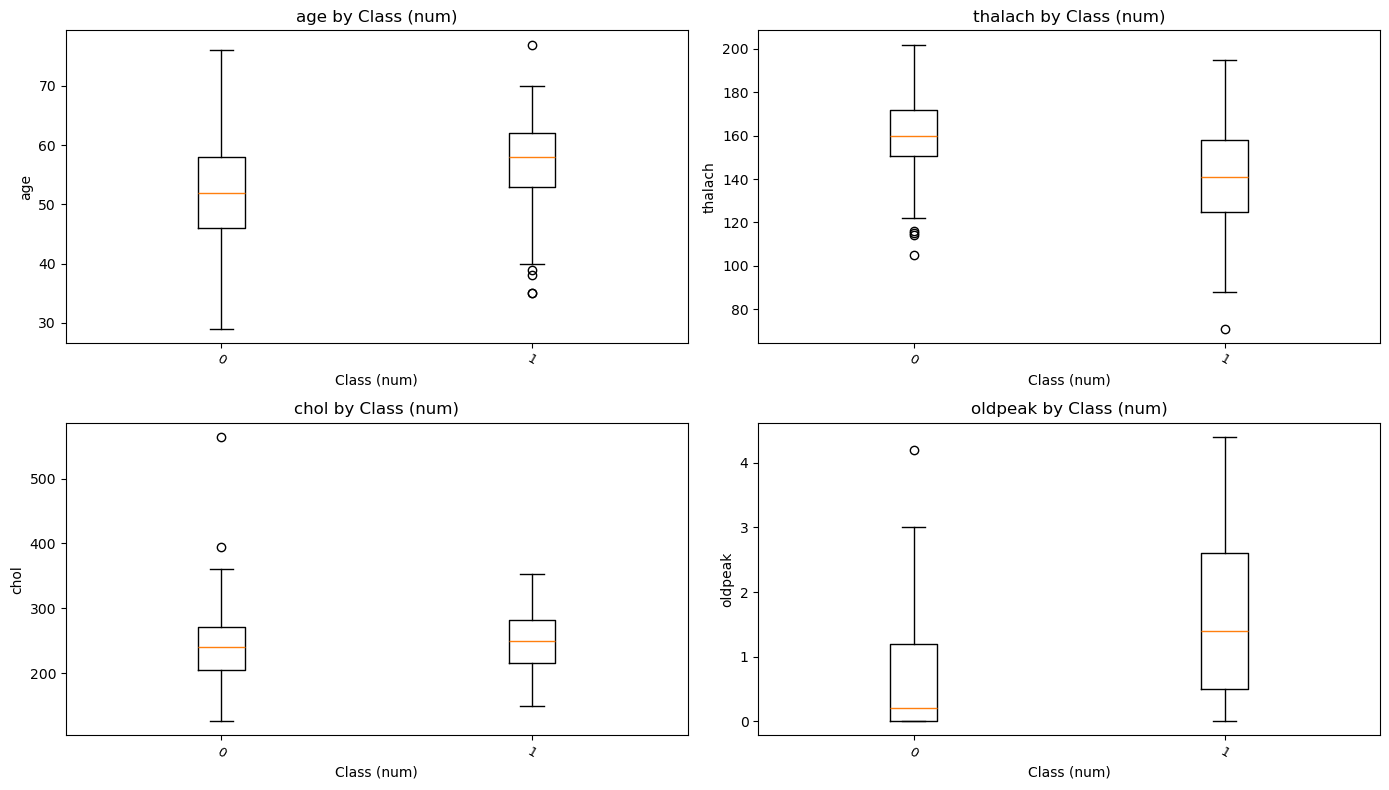

In [11]:
# List of numeric features for boxplots
selected_features = ["age", "thalach", "chol", "oldpeak"]

plt.figure(figsize=(14, 8))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(2, 2, i)
    # Boxplot for each feature grouped by 'num'
    data = [raw_data[raw_data["num"] == cls][feature] for cls in raw_data["num"].unique()]
    plt.boxplot(data, labels=[str(cls) for cls in raw_data["num"].unique()])
    plt.title(f"{feature} by Class (num)", fontsize=12)
    plt.xlabel("Class (num)", fontsize=10)
    plt.ylabel(feature, fontsize=10)
    plt.xticks(rotation=330, fontsize=9)
plt.tight_layout()
plt.savefig(f"{results_dir}/raw_boxplots_by_class.png", dpi=300)
plt.show()

<div style="background-color:#fce8e6; padding:15px; border-radius:5px; border: 2px solid #ff6666;">
    <h2 style="color:#ff6666;">✅ Visualization Section Completed</h2>
    <p style="font-size:14px; color:#cc0000;">
        This concludes the visualization section. The insights derived from these plots will be used to guide subsequent analyses 
        and modeling steps. If additional visualizations are required, they can be added here.
    </p>
</div>

## Preprocessing, Modelling & Tuning

In [12]:
# Create a pipeline to handle 'ca'
ca_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    StandardScaler()
)

# Create a pipeline to handle 'thal'
thal_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(sparse_output=False)
)

# Set up preprocessor
heart_disease_preprocessor = make_column_transformer(
    (ca_pipeline, ['ca']),  # Apply imputation and scaling to 'ca'
    (thal_pipeline, ['thal']),  # Apply imputation and encoding to 'thal'
    (OneHotEncoder(sparse_output=False), ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope']),
    (StandardScaler(), ["age", "trestbps", "chol", "thalach", "oldpeak"]),
    remainder='passthrough',
    verbose_feature_names_out=True
)

# Fit, transform, and save scaled data for reference only
heart_disease_preprocessor.fit(heart_disease_train)
scaled_heart_disease_train = heart_disease_preprocessor.transform(heart_disease_train)
scaled_heart_disease_test = heart_disease_preprocessor.transform(heart_disease_test)

scaled_heart_disease_train.to_csv("../data/processed/scaled_heart_disease_train.csv")
scaled_heart_disease_test.to_csv("../data/processed/scaled_heart_disease_test.csv")

In [13]:
X_train = heart_disease_train.drop(columns=['num'])
y_train = heart_disease_train['num']
X_test = heart_disease_test.drop(columns=['num'])
y_test = heart_disease_test['num']

In [14]:
def randomized_search(X_train, y_train, model, param_dist, n_iter=100, cv=5, random_state=123):
    """
    Performs RandomizedSearchCV on the specified model and returns the best model.
    
    Parameters:
    X_train : DataFrame
        Training features
    y_train : Series
        Training labels
    model : estimator
        The model to be tuned
    param_dist : dict
        Hyperparameter distribution for RandomizedSearchCV
    n_iter : int, optional, default=100
        Number of iterations for RandomizedSearchCV
    cv : int, optional, default=5
        Number of cross-validation folds
    random_state : int, optional, default=123
        Random seed for reproducibility

    Returns:
    best_model : estimator
        The best model after RandomizedSearchCV
    """
    # Perform RandomizedSearchCV
    random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                       n_iter=n_iter, cv=cv, n_jobs=-1, random_state=random_state,
                                       return_train_score=True)
    
    # Fit the model
    random_search.fit(X_train, y_train)

    # Return the best model found by RandomizedSearchCV
    return random_search.best_estimator_

In [15]:
# This function is taken from UBC DSCI 571 Course
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [16]:
results_dict = {}

models = {
    "Dummy": DummyClassifier(random_state=123),
    "Decision tree": DecisionTreeClassifier(random_state=123),
    "SVC": SVC(random_state=123),
    "Logistic Regression": LogisticRegression(random_state=123, max_iter=1000)
}

for model in models.items():
    pipe = make_pipeline(heart_disease_preprocessor, model[1])
    results_dict[model[0]] = mean_std_cross_val_scores(
        pipe, X_train, y_train, cv=5, return_train_score=True
    )

# Show the cross-validation results of baseline models
income_pred_results_df = pd.DataFrame(results_dict).T
income_pred_results_df

,fit_time,score_time,test_score,train_score
Dummy,0.008 (+/- 0.005),0.005 (+/- 0.005),0.543 (+/- 0.007),0.542 (+/- 0.002)
Decision tree,0.011 (+/- 0.003),0.004 (+/- 0.003),0.713 (+/- 0.048),1.000 (+/- 0.000)
SVC,0.010 (+/- 0.003),0.005 (+/- 0.002),0.844 (+/- 0.043),0.929 (+/- 0.017)
Logistic Regression,0.011 (+/- 0.002),0.006 (+/- 0.000),0.849 (+/- 0.027),0.889 (+/- 0.015)


In [17]:
# Parameter grid for tuning Decision Tree model
tree_param = {
    'dt__max_depth': [i for i in range(1, 101)],
    'dt__class_weight': [None, "balanced"]
}

# Set up a pipeline to include the preprocessor here, or it won't work when scoring on the test set
tree_pipe = Pipeline(steps=[
    ('preprocessor', heart_disease_preprocessor),
    ('dt', DecisionTreeClassifier(random_state=123))
])

best_tree_model = randomized_search(X_train, y_train, tree_pipe, tree_param)

# Calculate the train score (accuracy on training data)
train_score = best_tree_model.score(X_train, y_train)
print("Decision Tree Classifier Best Model Train Accuracy Score: ", train_score)

Decision Tree Classifier Best Model Train Accuracy Score:  0.9481132075471698


In [18]:
# Parameter grid for tuning SVC model
svc_param = {
    "svc__gamma": loguniform(1e-4, 1e3),
    "svc__C": loguniform(1e-4, 1e3),
    "svc__class_weight": [None, "balanced"]
}

# Set up a pipeline to include the preprocessor here, or it won't work when scoring on the test set
svc_pipe = Pipeline(steps=[
    ('preprocessor', heart_disease_preprocessor),
    ('svc', SVC(random_state=123))
])

best_svc_model = randomized_search(X_train, y_train, svc_pipe, svc_param)

# Calculate the train score (accuracy on training data)
train_score = best_svc_model.score(X_train, y_train)
print("SVC Best Model Train Accuracy Score: ", train_score)

SVC Best Model Train Accuracy Score:  0.8726415094339622


In [19]:
# Parameter grid for tuning Logistic Regression model
lr_param = {
    "lr__C": loguniform(1e-4, 1e3),
    'lr__class_weight': [None, 'balanced']
}

# Set up a pipeline to include the preprocessor here, or it won't work when scoring on the test set
lr_pipe = Pipeline(steps=[
    ('preprocessor', heart_disease_preprocessor),
    ('lr', LogisticRegression(random_state=123, max_iter=1000))
])

best_lr_model = randomized_search(X_train, y_train, lr_pipe, lr_param)

# Calculate the train score (accuracy on training data)
train_score = best_lr_model.score(X_train, y_train)
print("Logistic Regression Best Model Train Accuracy Score: ", train_score)

Logistic Regression Best Model Train Accuracy Score:  0.8820754716981132


In [20]:
results_dict = {}
best_model_pipes = {
    "Best Decision tree": best_tree_model,
    "Best SVC": best_svc_model,
    "Best Logistic Regression": best_lr_model
}

# Preprocessor included in pipelines
for model in best_model_pipes.items():
    pipe = model[1]
    results_dict[model[0]] = mean_std_cross_val_scores(
        pipe, X_train, y_train, cv=5, return_train_score=True
    )

# Cross-validation results for each best-model pipelines
best_model_cv_results_df = pd.DataFrame(results_dict).T
best_model_cv_results_df

,fit_time,score_time,test_score,train_score
Best Decision tree,0.013 (+/- 0.007),0.003 (+/- 0.004),0.778 (+/- 0.037),0.960 (+/- 0.014)
Best SVC,0.008 (+/- 0.008),0.008 (+/- 0.007),0.849 (+/- 0.040),0.875 (+/- 0.007)
Best Logistic Regression,0.009 (+/- 0.003),0.005 (+/- 0.003),0.858 (+/- 0.053),0.881 (+/- 0.009)


In [21]:
# Calculate the test score (accuracy on testing data)

svc_test_score = best_svc_model.score(X_test, y_test)
print("SVC Best Model Test Accuracy Score: ", svc_test_score)
lr_test_score = best_lr_model.score(X_test, y_test)
print("Logistic Regression Best Model Test Accuracy Score: ", lr_test_score)

SVC Best Model Test Accuracy Score:  0.8241758241758241
Logistic Regression Best Model Test Accuracy Score:  0.8351648351648352


## Discussion

In the final cross-validation results, both the best SVC and best Logistic Regression achieve excellent test scores. The small gap between their training and test scores suggests that both models generalize well, with minimal overfitting. However, Logistic Regression has a smaller gap between training and test scores (0.023) compared to SVC (0.026), suggesting that it might generalize slightly better than SVC.

This is further confirmed by the test scores, which show that Logistic Regression slightly outperforms SVC on unseen data.

To better understand the relationship between each feature and heart disease presence, we examine the coefficients obtained from the logistic regression model. Each coefficient indicates how the corresponding feature influences the likelihood of heart disease. Positive coefficients suggest that as the feature increases, the likelihood of having heart disease increases as well, while negative coefficients suggest the opposite.

In [22]:
# Get coefficients for best logistic regression model
log_reg_coef = best_lr_model.named_steps['lr'].coef_[0]

# Get feature names
feature_names = best_lr_model.named_steps['preprocessor'].get_feature_names_out()

# Create and sort DataFrame by feature coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': log_reg_coef
}).sort_values(by='Coefficient', ascending=False)

coef_df

,Feature,Coefficient
0,pipeline-1__ca,0.674653
9,onehotencoder__cp_4.0,0.614785
3,pipeline-2__thal_7.0,0.450091
24,standardscaler__oldpeak,0.400388
16,onehotencoder__exang_1.0,0.323725
5,onehotencoder__sex_1.0,0.297677
18,onehotencoder__slope_2.0,0.275565
21,standardscaler__trestbps,0.253341
14,onehotencoder__restecg_2.0,0.168724
10,onehotencoder__fbs_0.0,0.161019


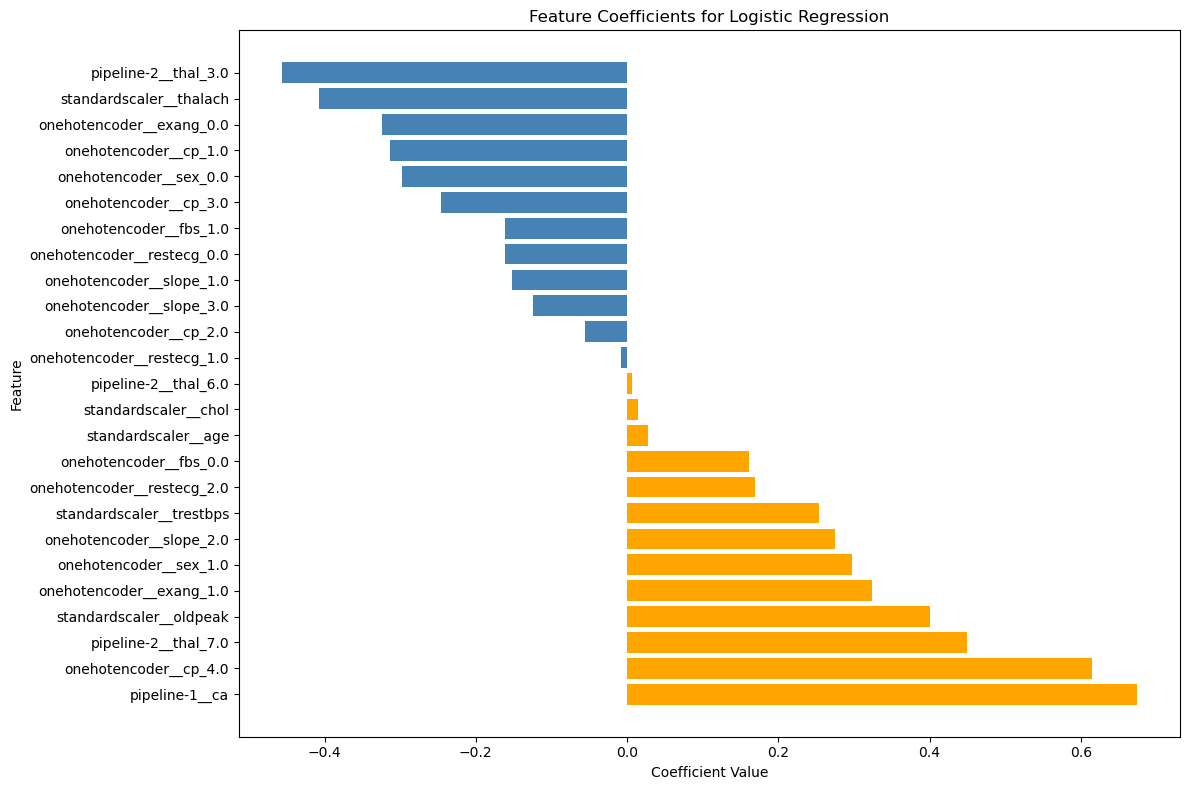

In [23]:
# Plot the coefficients bar chart
plt.figure(figsize=(12, 8))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=coef_df['Coefficient'].apply(lambda x: 'orange' if x > 0 else 'steelblue'))

plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Coefficients for Logistic Regression')

plt.tight_layout()
plt.savefig(f"{results_dir}/log_reg_feature_coefficients.png", dpi=300)
plt.show()

From the chart above, we can see that features like `ca`, `oldpeak`, and `trestbps` have relatively high positive coefficients, meaning they strongly influence the prediction of heart disease. This makes sense, as research shows that high blood pressure is one of the most important causes of heart disease(Fuchs & Whelton, 2020). For oldpeak specifically, research shows that ST depression during exercise is linked to higher risk of heart disease(Carlén et al., 2019). In contrast, features like `thalach` have large negative coefficients, suggesting they are linked to a lower likelihood of heart disease. Features like `age` and `chol`, however, show little impact, as their coefficients are close to zero.

Interestingly, females (`sex` = 0) are more likely to be free of heart disease, as indicated by the large negative coefficient for `onehotencoder__sex_0.0`. In contrast, males (`sex` = 1) are more likely to have heart disease, as reflected by the high positive coefficient for `onehotencoder__sex_1.0`. This is supported by Regitz-Zagrosek and Gebhard's reseach(2023), which highlights how biological sex differences, such as premenopausal women having a relative protection from coronary artery disease.

However, there are some limitations of this study. First of all, as categorical features were split into multiple binary columns, interpreting the coefficients for these encoded variables can be tricky. It can be difficult to directly correlate the coefficients with the original feature, and whether this approach is reasonable should also be questioned.

Additionally, while the model's coefficients offer useful insights, they should be taken with caution. Further exploration into feature relationships and more advanced modeling techniques might be required to better understand the complexities of predicting heart disease.

In [24]:
lr_predictions = best_lr_model.predict(X_test)

# Identify misclassified indices
misclassified_indices = np.where(y_test != lr_predictions)[0]

# Display a sample of misclassified examples
print("Misclassified Examples (Logistic Regression):")
print(X_test.iloc[misclassified_indices].head())  # Display the first few misclassified feature rows
print("True Labels:", y_test.iloc[misclassified_indices].head().values)  # True labels for misclassified examples
print("Predicted Labels:", lr_predictions[misclassified_indices][:5])  # Predicted labels for these examples

Misclassified Examples (Logistic Regression):
      age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
218  64.0  0.0  4.0     130.0  303.0  0.0      0.0    122.0    0.0      2.0   
16   48.0  1.0  2.0     110.0  229.0  0.0      0.0    168.0    0.0      1.0   
199  59.0  1.0  1.0     160.0  273.0  0.0      2.0    125.0    0.0      0.0   
246  58.0  1.0  4.0     100.0  234.0  0.0      0.0    156.0    0.0      0.1   
32   64.0  1.0  3.0     140.0  335.0  0.0      0.0    158.0    0.0      0.0   

     slope   ca thal  
218    2.0  2.0  3.0  
16     3.0  0.0  7.0  
199    1.0  0.0  3.0  
246    1.0  1.0  7.0  
32     1.0  0.0  3.0  
True Labels: [0 1 1 1 1]
Predicted Labels: [1 0 0 0 0]


False Positives (e.g., index 218): Predicted as `1` (positive for heart disease), but true label is `0`.  
This individual has a high cholesterol level (`chol` = 303), moderate `oldpeak` (2.0), and significant `ca` = 2.0, which might make the model lean toward predicting heart disease incorrectly.


False Negatives (e.g., indices 16, 199, 246, 32): Predicted as `0` (no heart disease), but true label is `1`.  
Many of these cases involve features like high `thalach` (e.g., 168, 158) and `slope` = 3.0 or 1.0, which the model might not weigh heavily enough.

Overall the Loogistic Regression model performs well and could be useful as a first-pass screening tool in a clinical setting, but there are ways we can make it even better. First, we can take a closer look at the misclassified examples and compare them to correctly classified ones. This could help us identify features or patterns the model struggles with and guide us in improving the features or adding new ones that capture important relationships.

Next, we could test other classifiers to see if they perform better. For example, Random Forests are good at handling feature interactions automatically, which could help improve accuracy.

Finally, instead of just giving a prediction, the model could provide a probability for each class. This would help clinicians understand how confident the model is in its predictions. For low-confidence cases, additional tests or evaluations could be done to avoid mistakes.

These changes could make the model even more accurate and useful in practice.

# References

Dua, D., Dheeru, D., & Graff, C. (2017). *UCI Machine Learning Repository*. University of California, Irvine. https://archive.ics.uci.edu/ml

Cleveland Clinic Foundation. (1988). Heart disease data set. In *Proceedings of Machine Learning and Medical Applications*.

Attia, P. (2023, February 15). Peter on the four horsemen of chronic disease. PeterAttiaMD.com. https://peterattiamd.com/peter-on-the-four-horsemen-of-chronic-disease/

Bui, T. (2024, October 15). Cardiovascular disease is rising again after years of improvement. Stat News. https://www.statnews.com/2024/10/15/cardiovascular-disease-rising-experts-on-causes/

Centers for Disease Control and Prevention (CDC). (2022). Leading causes of death. National Center for Health Statistics. https://www.cdc.gov/nchs/fastats/leading-causes-of-death.htm

Detrano, R., Jánosi, A., Steinbrunn, W., Pfisterer, M., Schmid, J., Sandhu, S., Guppy, K., Lee, S., & Froelicher, V. (1988). Heart Disease UCI dataset. UC Irvine Machine Learning Repository. https://archive.ics.uci.edu/dataset/45/heart+disease

Carlén, A., Gustafsson, M., Åström Aneq, M., & Nylander, E. (2019). Exercise-induced ST depression in an asymptomatic population without coronary artery disease. Scandinavian Cardiovascular Journal, 53(4), 206–212. https://doi.org/10.1080/14017431.2019.1626021

Fuchs, F. D., & Whelton, P. K. (2020). High Blood Pressure and Cardiovascular Disease. Hypertension, 75(2), 285–292. https://doi.org/10.1161/HYPERTENSIONAHA.119.14240

Regitz-Zagrosek, V., & Gebhard, C. (2023). Gender medicine: Effects of sex and gender on cardiovascular disease manifestation and outcomes. Nature Reviews Cardiology, 20(4), 236–247. https://doi.org/10.1038/s41569-022-00797-4